# Clustering Districts in Downtown Milan

### Author: Francesco Bellogi

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**Milan** is **Italy's financial capital** and it's by far the most economically lively city in Italy. Milan is also particularly famous for its *fashion weeks*  and for its *lyfestyle*.  
With around **1,3 millions inhabitants** it's the second most populous city in Italy and also one of the most densely populated. People from all around the country move to Milan to chase a career and in the last year Milan has attracted a lot of people from all around the world.    
Milan is a **fast pace growing city** in which people enjoy going out for dinner, for *aperitivo*, for shopping and that makes it an optimal place to open a restaurant, a shop, a club. On the other hand, not all districts are the same, some of them have been growing over the years and others have fallen behind. **Many businesses are opening and many are closing**.  
Having a more clear picture of the current situation of the various in districts in downtown Milan can be extremely useful for anybody who is looking for business opportunities, for a family wanting to buy a house, for the local government having to distribute finances.

## Data <a name="data"></a>

I built the dataset for this analysis from scratch, collecting pieces from different sources. I obtained the list of names of districts is Milan by **scraping the relative Wikipedia page**. The resulting list of names needed a lot of **cleaning**. Once cleaned I was able to obtain the **geo-spatial coordinates** for each districts using the python **geopy** package for **geocoding**.  
After that I collected for each district the **venues in a radius of 300 miles** through the **Foursquare API**. Following some more data wrangling I obtained my dataset ready for clustering, containing all relevant venues for each districts. For example it will display Brera's Art Galleries, Cafes and Restaurants.  
A view of the dataset will be provided in upcoming sections of the report.

First of all import all the libraries I will be using throughout the project as follows

In [ ]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import geopy
from geopy.exc import GeocoderTimedOut
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

### Scraping the wikipedia page to obtain the list of districts in Milan

In [269]:
table = pd.read_html('https://it.wikipedia.org/wiki/Municipi_di_Milano')
df=table[2]
df

,0,1,2,3,4,5,6
0,# Denominazione Superficie(km²) Abitanti(31.12...,NaN,NaN,NaN,NaN,NaN,NaN
1,#,Denominazione,Superficie(km²),Abitanti(31.12.2018),Densità(ab/km²),Quartieri compresi[4] [5],Localizzazione
2,Municipio 1,Centro storico,967,98 531,10 189,"Cordusio, Cinque Vie, Brisa, Brera, Case Rotte...",NaN
3,Municipio 2,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",1258,162 090,12 884,"Stazione Centrale, Loreto, Turro, Crescenzago,...",NaN
4,Municipio 3,"Città Studi, Lambrate, Venezia",1423,144 110,10 127,"Porta Venezia, Porta Monforte, Casoretto, Rott...",NaN
5,Municipio 4,"Vittoria, Forlanini",2095,161 551,7 711,"Porta Vittoria, Porta Romana, Acquabella, Sena...",NaN
6,Municipio 5,"Vigentino, Chiaravalle, Gratosoglio",2987,126 089,4 221,"Porta Vigentina, Porta Lodovica, Porta Ticines...",NaN
7,Municipio 6,"Barona, Lorenteggio",1828,151 291,8 276,"Porta Genova, Conchetta, Moncucco, Barona, Qua...",NaN
8,Municipio 7,"Baggio, De Angeli, San Siro",3134,175 465,5 598,"Vepra, Quartiere De Angeli - Frua, San Siro, Q...",NaN
9,Municipio 8,"Fiera, Gallaratese, Quarto Oggiaro",2372,188 367,7 941,"Porta Volta, Bullona, Ghisolfa, Portello, Cagn...",NaN


In [271]:
df=df.iloc[2:11,0:6].reset_index(drop=True)
df.columns=['Municipio', 'Denominazione','Area_km2', 'Population', 'Population_density', 'Districts']
df

,Municipio,Denominazione,Area_km2,Population,Population_density,Districts
0,Municipio 1,Centro storico,967,98 531,10 189,"Cordusio, Cinque Vie, Brisa, Brera, Case Rotte..."
1,Municipio 2,"Stazione Centrale, Gorla, Turro, Greco, Cresce...",1258,162 090,12 884,"Stazione Centrale, Loreto, Turro, Crescenzago,..."
2,Municipio 3,"Città Studi, Lambrate, Venezia",1423,144 110,10 127,"Porta Venezia, Porta Monforte, Casoretto, Rott..."
3,Municipio 4,"Vittoria, Forlanini",2095,161 551,7 711,"Porta Vittoria, Porta Romana, Acquabella, Sena..."
4,Municipio 5,"Vigentino, Chiaravalle, Gratosoglio",2987,126 089,4 221,"Porta Vigentina, Porta Lodovica, Porta Ticines..."
5,Municipio 6,"Barona, Lorenteggio",1828,151 291,8 276,"Porta Genova, Conchetta, Moncucco, Barona, Qua..."
6,Municipio 7,"Baggio, De Angeli, San Siro",3134,175 465,5 598,"Vepra, Quartiere De Angeli - Frua, San Siro, Q..."
7,Municipio 8,"Fiera, Gallaratese, Quarto Oggiaro",2372,188 367,7 941,"Porta Volta, Bullona, Ghisolfa, Portello, Cagn..."
8,Municipio 9,"Stazione Garibaldi, Niguarda",2112,187 773,8 890,"Porta Garibaldi, Porta Nuova, Centro Direziona..."


As we can see, district names are **stored as comma separated values** in the column **Districts**.   
I need translate the column District into a **different row for each district name**.

In [272]:
df1=df[['Districts', 'Municipio']]
df2=df1.set_index('Municipio').Districts.str.split(',', expand=True).stack().reset_index('Municipio')
df2.columns=['area', 'district']
df2

,area,district
0,Municipio 1,Cordusio
1,Municipio 1,Cinque Vie
2,Municipio 1,Brisa
3,Municipio 1,Brera
4,Municipio 1,Case Rotte
...,...,...
14,Municipio 9,Bovisa
15,Municipio 9,Affori
16,Municipio 9,Bruzzano
17,Municipio 9,Comasina


In [273]:
df2.shape

(161, 2)

Finally I obtained **161 districts**.

### Geocoding

As a starting point I collect the **coordinates** of **Milan**. These coordinates will be the center of my geo spatial analysis and it is useful to have them ready to know if the coordinates I am getting for the different districts make sense or not.

In [171]:
address = 'Milano, Italia'

geolocator = Nominatim(user_agent="mi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milan are 45.4668, 9.1905.


Now I can retrieve the geographical coordinates for all the districts in my dataset.  
To do that, I first create a new variable 'address' as 'district, Milano, Lombardi'. Then I feed the 'address' variable to the geocoder function to obtain the coordinates.

In [172]:
def do_geocode(address):
    geopy = Nominatim(user_agent="mi_explorer")
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [173]:
df2.loc[4,'district'] = 'Scala'
df2['address']=df2['district']+', Milano, Lombardia'
df2.head()

,area,district,address
0,Municipio 1,Cordusio,"Cordusio, Milano, Lombardia"
1,Municipio 1,Cinque Vie,"Cinque Vie, Milano, Lombardia"
2,Municipio 1,Brisa,"Brisa, Milano, Lombardia"
3,Municipio 1,Brera,"Brera, Milano, Lombardia"
4,Municipio 1,Scala,"Scala, Milano, Lombardia"


In [174]:
df2['location'] = df2['address'].apply(do_geocode)

In [175]:
df2['point'] = df2['location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [176]:
df2.head()

,area,district,address,location,point
0,Municipio 1,Cordusio,"Cordusio, Milano, Lombardia","(Cordusio, Municipio 1, Milano, Lombardia, Ita...","(45.4658323, 9.1860936, 0.0)"
1,Municipio 1,Cinque Vie,"Cinque Vie, Milano, Lombardia","(Cinque Vie, Municipio 1, Milano, Lombardia, I...","(45.4633539, 9.1839004, 0.0)"
2,Municipio 1,Brisa,"Brisa, Milano, Lombardia","(Brisa, Municipio 1, Milano, Lombardia, Italia...","(45.4645591, 9.1804824, 0.0)"
3,Municipio 1,Brera,"Brera, Milano, Lombardia","(Brera, Municipio 1, Milano, Lombardia, 20121,...","(45.4715187, 9.1877351, 0.0)"
4,Municipio 1,Scala,"Scala, Milano, Lombardia","(Teatro alla Scala, Piazza della Scala, Scala,...","(45.46760475, 9.189119523129573, 0.0)"


In [178]:
df2[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df2['point'].tolist(), index=df2.index)

In [182]:
df3=df2.dropna()
df3.head()

,area,district,address,location,point,latitude,longitude,altitude
0,Municipio 1,Cordusio,"Cordusio, Milano, Lombardia","(Cordusio, Municipio 1, Milano, Lombardia, Ita...","(45.4658323, 9.1860936, 0.0)",45.465832,9.186094,0.0
1,Municipio 1,Cinque Vie,"Cinque Vie, Milano, Lombardia","(Cinque Vie, Municipio 1, Milano, Lombardia, I...","(45.4633539, 9.1839004, 0.0)",45.463354,9.183900,0.0
2,Municipio 1,Brisa,"Brisa, Milano, Lombardia","(Brisa, Municipio 1, Milano, Lombardia, Italia...","(45.4645591, 9.1804824, 0.0)",45.464559,9.180482,0.0
3,Municipio 1,Brera,"Brera, Milano, Lombardia","(Brera, Municipio 1, Milano, Lombardia, 20121,...","(45.4715187, 9.1877351, 0.0)",45.471519,9.187735,0.0
4,Municipio 1,Scala,"Scala, Milano, Lombardia","(Teatro alla Scala, Piazza della Scala, Scala,...","(45.46760475, 9.189119523129573, 0.0)",45.467605,9.189120,0.0


Once I have all the coordinates I need in my dataset I can draw a **map of Milan** on which I add a blue circle **markers** to visualize all the districts on the map.

In [184]:
# create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df3['latitude'], df3['longitude'], df3['area'], df3['district']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

In this analysis I decided to **concentrate only on the most central part of Milan**.   
As you can see from the map above, Milan develops itself in **concentric circles**. I will focus on one the internal circles, meaning all districts belonging to the "Municipio 1" area.

In [185]:
df4=df3[df3['area']=='Municipio 1']
df4

,area,district,address,location,point,latitude,longitude,altitude
0,Municipio 1,Cordusio,"Cordusio, Milano, Lombardia","(Cordusio, Municipio 1, Milano, Lombardia, Ita...","(45.4658323, 9.1860936, 0.0)",45.465832,9.186094,0.0
1,Municipio 1,Cinque Vie,"Cinque Vie, Milano, Lombardia","(Cinque Vie, Municipio 1, Milano, Lombardia, I...","(45.4633539, 9.1839004, 0.0)",45.463354,9.183900,0.0
2,Municipio 1,Brisa,"Brisa, Milano, Lombardia","(Brisa, Municipio 1, Milano, Lombardia, Italia...","(45.4645591, 9.1804824, 0.0)",45.464559,9.180482,0.0
3,Municipio 1,Brera,"Brera, Milano, Lombardia","(Brera, Municipio 1, Milano, Lombardia, 20121,...","(45.4715187, 9.1877351, 0.0)",45.471519,9.187735,0.0
4,Municipio 1,Scala,"Scala, Milano, Lombardia","(Teatro alla Scala, Piazza della Scala, Scala,...","(45.46760475, 9.189119523129573, 0.0)",45.467605,9.189120,0.0
5,Municipio 1,Sant’Ambrogio,"Sant’Ambrogio, Milano, Lombardia","(Sant'Ambrogio, Via Olona, Sant'Ambrogio, Muni...","(45.4613906, 9.1729167, 0.0)",45.461391,9.172917,0.0
6,Municipio 1,Carrobbio,"Carrobbio, Milano, Lombardia","(Carrobbio, Municipio 1, Milano, Lombardia, It...","(45.4602625, 9.1816951, 0.0)",45.460262,9.181695,0.0
7,Municipio 1,Verziere,"Verziere, Milano, Lombardia","(Verziere, Municipio 1, Milano, Lombardia, Ita...","(45.4630937, 9.1969247, 0.0)",45.463094,9.196925,0.0
8,Municipio 1,Pasquirolo,"Pasquirolo, Milano, Lombardia","(Pasquirolo, Municipio 1, Milano, Lombardia, I...","(45.464444650000004, 9.19507878278484, 0.0)",45.464445,9.195079,0.0
9,Municipio 1,Borgonuovo,"Borgonuovo, Milano, Lombardia","(Borgonuovo, Municipio 1, Milano, Lombardia, I...","(45.4716746, 9.1915708, 0.0)",45.471675,9.191571,0.0


In [276]:
map_milan = folium.Map(location=[latitude, longitude], zoom_start=14)
map_milan

for lat, lng, borough, neighborhood in zip(df4['latitude'], df4['longitude'], df4['area'], df4['district']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=12,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

In the map above we can see the **heart of Milan**, inside the ancient walls that are still clearly visible on the map forming a polygon inside of which we have all the **historic districts** of "Municipio".  
In the upcoming part of the analysis I am going to **collect all the main venues** of these districts using the **Forsquare API**. Then I will try to **clusterize** them based of those venues.

I create the variables needed to work with the Forsquare API containing credentials.  
Then I create the function to retrive the venues in a 300 meters radius from the location denoted by longitude and latitude.

In [187]:
CLIENT_ID = 'OJRFKEOQXERN15XHVDMU0LBI4ERZNETBKWRLUGBLXSEGMQLQ' # Foursquare ID
CLIENT_SECRET = 'FBXN3GYX10OBHBBU5SXIYZO3LJJ0BWMZCGSA0AJMHXX2BWOX' #  Foursquare Secret
VERSION = '20190605' # Foursquare API version


In [188]:
def getNearbyVenues(names, latitudes, longitudes, radius=300, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [189]:
milano_dt = getNearbyVenues(names=df4['district'],
                                   latitudes=df4['latitude'],
                                   longitudes=df4['longitude']
                                  )

Cordusio
 Cinque Vie
 Brisa
 Brera
Scala
 Sant’Ambrogio
 Carrobbio
 Verziere
 Pasquirolo
 Borgonuovo
 Brolo – Pantano
 Crocetta
 Quadronno
 Vetra
 Brera
 Porta Tenaglia
 Porta Sempione
 Porta Magenta
 San Marco
 Guastalla
 Borgogna


In [190]:
milano_dt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cordusio,45.465832,9.186094,Starbucks Reserve Roastery,45.464920,9.186153,Coffee Shop
1,Cordusio,45.465832,9.186094,Venchi,45.465214,9.187340,Ice Cream Shop
2,Cordusio,45.465832,9.186094,Park Hyatt Milan,45.465532,9.188911,Hotel
3,Cordusio,45.465832,9.186094,Bialetti Store,45.464775,9.188343,Kitchen Supply Store
4,Cordusio,45.465832,9.186094,Andry,45.467240,9.184450,Italian Restaurant


In the above table we can see some of the venues located around Cordusio, a very central district.  
We can see we have a Starbucks that was the first Starbucks to open in Italy not long ago, Venchi which is a very famous and also very expensive italian _gelateria_ , a Bialetti Store that sells very famous branded _Mocas_ for making coffee. These seem to be venues for tourist, in fact Cordusio is a district always full of tourist being near the Duomo.

As next step, I count how many venues we found in each district and how many different categories of venues we have in the dataframe.

In [253]:
milano_count_venue=milano_dt.groupby('Neighborhood').count()
milano_count_venue=milano_count_venue[['Venue']].reset_index()
milano_count_venue

,Neighborhood,Venue
0,Borgogna,68
1,Borgonuovo,18
2,Brera,136
3,Brisa,10
4,Brolo – Pantano,38
5,Carrobbio,63
6,Cinque Vie,51
7,Crocetta,23
8,Guastalla,13
9,Pasquirolo,68


In [279]:
# Average number of venues per districts:
milano_count_venue.mean()

Venue    44.95
dtype: float64

In [192]:
print('There are {} uniques categories.'.format(len(milano_dt['Venue Category'].unique())))

There are 137 uniques categories.


We can immediately notice the __Brera__ district __standing out with 136 venues__. Brera is considered the __most attractive district in Milan__ thanks to its art galleries, monuments, high fashon stores, cafes and restaurants.  
At the bottom of the list with just 4 venues we find Quadronno, a peaceful and residential district (where I live).  
Overall we have __137 unique veneus categories__.

I then transform my dataframe creating a __dummy variable for each venue category__. After that I __group by__ neighborhood summing the values for each dummy.
In the new dataframe, the different columns will tell us how many venues of that category are present in that neighborhood.

In [193]:
# one hot encoding
milano_dt_onehot = pd.get_dummies(milano_dt[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
milano_dt_onehot['Neighborhood'] = milano_dt['Neighborhood'] 

# move neighborhood column to the first column
Neighborhood = milano_dt_onehot['Neighborhood']
milano_dt_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
milano_dt_onehot.insert(0, 'Neighborhood', Neighborhood)

# group by neighborhood
milano_dt_grp = milano_dt_onehot.groupby('Neighborhood').sum().reset_index()
milano_dt_grp

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auditorium,Bakery,Bar,...,Theater,Thrift / Vintage Store,Toy / Game Store,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Watch Shop,Wine Bar,Winery,Women's Store
0,Borgogna,1,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,1,0,0,0
1,Borgonuovo,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Brera,0,0,0,4,4,0,0,2,4,...,0,0,0,0,2,0,0,4,0,0
3,Brisa,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,Brolo – Pantano,0,1,0,0,0,1,0,2,1,...,0,0,0,2,0,1,0,1,0,0
5,Carrobbio,0,0,0,1,0,0,0,0,1,...,1,2,0,0,0,0,0,0,0,0
6,Cinque Vie,0,0,1,1,0,0,0,0,2,...,0,0,1,0,0,1,0,0,0,1
7,Crocetta,0,0,0,0,0,0,0,2,1,...,1,0,0,2,0,0,0,0,0,0
8,Guastalla,0,0,0,0,0,0,0,2,0,...,0,0,0,1,0,0,0,0,0,0
9,Pasquirolo,1,0,0,0,0,2,0,0,2,...,0,0,2,0,0,1,1,2,0,2


To characterize each neighborhood I can find out its __top 10 most common categories of venues__ as follows.

In [194]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [255]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = milano_dt_grp['Neighborhood']

for ind in np.arange(milano_dt_grp.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(milano_dt_grp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Borgogna,Boutique,Clothing Store,Furniture / Home Store,Italian Restaurant,Sporting Goods Shop,Cocktail Bar,Cosmetics Shop,Sandwich Place,Plaza,Shoe Store
1,Borgonuovo,Hotel,Boutique,Cocktail Bar,Bookstore,Japanese Restaurant,Lounge,Park,Restaurant,College Arts Building,Spa
2,Brera,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Pizza Place,Hotel,Art Museum,Arts & Crafts Store,Plaza,Lounge,Wine Bar
3,Brisa,Ice Cream Shop,Café,Theater,Dessert Shop,Sandwich Place,Chocolate Shop,Monument / Landmark,Pizza Place,Grocery Store,Gym
4,Brolo – Pantano,Coffee Shop,Bistro,Italian Restaurant,Bakery,Hotel,Café,Burger Joint,Pizza Place,Tram Station,Sandwich Place
5,Carrobbio,Italian Restaurant,Café,Ice Cream Shop,Cocktail Bar,Salad Place,Gift Shop,Fast Food Restaurant,Thrift / Vintage Store,Historic Site,Pizza Place
6,Cinque Vie,Italian Restaurant,Plaza,Cosmetics Shop,Ice Cream Shop,Café,Sandwich Place,Gift Shop,Hotel,Furniture / Home Store,Coffee Shop
7,Crocetta,Italian Restaurant,Tram Station,Pizza Place,Bakery,Hotel,Salad Place,Ice Cream Shop,Theater,Indian Restaurant,Bar
8,Guastalla,Bakery,Restaurant,Italian Restaurant,Food Truck,Farmers Market,Park,Pizza Place,Clothing Store,Bus Stop,Pub
9,Pasquirolo,Clothing Store,Sporting Goods Shop,Cocktail Bar,Plaza,Italian Restaurant,Bistro,Furniture / Home Store,Hotel,Asian Restaurant,Bar


In [256]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.join(milano_count_venue.set_index('Neighborhood'), on='Neighborhood')
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
0,Borgogna,Boutique,Clothing Store,Furniture / Home Store,Italian Restaurant,Sporting Goods Shop,Cocktail Bar,Cosmetics Shop,Sandwich Place,Plaza,Shoe Store,68
1,Borgonuovo,Hotel,Boutique,Cocktail Bar,Bookstore,Japanese Restaurant,Lounge,Park,Restaurant,College Arts Building,Spa,18
2,Brera,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Pizza Place,Hotel,Art Museum,Arts & Crafts Store,Plaza,Lounge,Wine Bar,136
3,Brisa,Ice Cream Shop,Café,Theater,Dessert Shop,Sandwich Place,Chocolate Shop,Monument / Landmark,Pizza Place,Grocery Store,Gym,10
4,Brolo – Pantano,Coffee Shop,Bistro,Italian Restaurant,Bakery,Hotel,Café,Burger Joint,Pizza Place,Tram Station,Sandwich Place,38
5,Carrobbio,Italian Restaurant,Café,Ice Cream Shop,Cocktail Bar,Salad Place,Gift Shop,Fast Food Restaurant,Thrift / Vintage Store,Historic Site,Pizza Place,63
6,Cinque Vie,Italian Restaurant,Plaza,Cosmetics Shop,Ice Cream Shop,Café,Sandwich Place,Gift Shop,Hotel,Furniture / Home Store,Coffee Shop,51
7,Crocetta,Italian Restaurant,Tram Station,Pizza Place,Bakery,Hotel,Salad Place,Ice Cream Shop,Theater,Indian Restaurant,Bar,23
8,Guastalla,Bakery,Restaurant,Italian Restaurant,Food Truck,Farmers Market,Park,Pizza Place,Clothing Store,Bus Stop,Pub,13
9,Pasquirolo,Clothing Store,Sporting Goods Shop,Cocktail Bar,Plaza,Italian Restaurant,Bistro,Furniture / Home Store,Hotel,Asian Restaurant,Bar,68


Looking at the above table, we can observe how Italian Restaurant is the most common venue category in around half the districts and even when it is not, it is pretty much always in the top3. This is not suprising given that we are looking at the most central area of Milan, where traffic is limited for cars and thousands of people (especially tourists) walk around mostly looking for food.

### Clustering

For the __clustering__ analysis I am using the __k-means__ method. The cluster will be created based on which and how many venues of each category are present in the neighborhood.
In order to __chose the best value of k__ in the k-means algorithm, I will try out 10 different values of k (from 1 to 10) and plot the meausure of distortion for each iteration.
We know that as the value of k grows the distortion decreases, to choose the best k I will apply the ___elbow rule___ by looking at the plot.

In [257]:
milan_dt_grp_clustering = milano_dt_grp.drop('Neighborhood', 1)

In [258]:
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(milan_dt_grp_clustering)
    distortions.append(kmeanModel.inertia_)

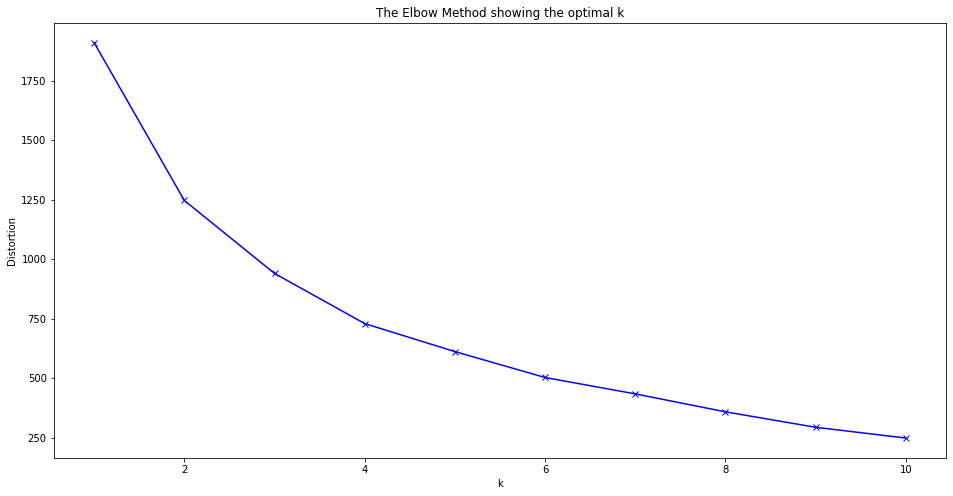

In [259]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Unfortunately, there is __no clear elbow__. Nonetheless, at k=4 the slope seems to get flatter suggesting us that __k=4 may be a good candidate__.

In [260]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milan_dt_grp_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [261]:
milano_dt_merged = df4

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
milano_dt_merged = milano_dt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='district')

milano_dt_merged.head()

,area,district,address,location,point,latitude,longitude,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
0,Municipio 1,Cordusio,"Cordusio, Milano, Lombardia","(Cordusio, Municipio 1, Milano, Lombardia, Ita...","(45.4658323, 9.1860936, 0.0)",45.465832,9.186094,0.0,3,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Monument / Landmark,Sandwich Place,Cosmetics Shop,Bakery,Café,Food Court,53
1,Municipio 1,Cinque Vie,"Cinque Vie, Milano, Lombardia","(Cinque Vie, Municipio 1, Milano, Lombardia, I...","(45.4633539, 9.1839004, 0.0)",45.463354,9.183900,0.0,3,Italian Restaurant,Plaza,Cosmetics Shop,Ice Cream Shop,Café,Sandwich Place,Gift Shop,Hotel,Furniture / Home Store,Coffee Shop,51
2,Municipio 1,Brisa,"Brisa, Milano, Lombardia","(Brisa, Municipio 1, Milano, Lombardia, Italia...","(45.4645591, 9.1804824, 0.0)",45.464559,9.180482,0.0,0,Ice Cream Shop,Café,Theater,Dessert Shop,Sandwich Place,Chocolate Shop,Monument / Landmark,Pizza Place,Grocery Store,Gym,10
3,Municipio 1,Brera,"Brera, Milano, Lombardia","(Brera, Municipio 1, Milano, Lombardia, 20121,...","(45.4715187, 9.1877351, 0.0)",45.471519,9.187735,0.0,1,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Pizza Place,Hotel,Art Museum,Arts & Crafts Store,Plaza,Lounge,Wine Bar,136
4,Municipio 1,Scala,"Scala, Milano, Lombardia","(Teatro alla Scala, Piazza della Scala, Scala,...","(45.46760475, 9.189119523129573, 0.0)",45.467605,9.189120,0.0,3,Italian Restaurant,Hotel,Ice Cream Shop,Lounge,Bar,Clothing Store,Coffee Shop,Bookstore,Monument / Landmark,Pastry Shop,57


In [262]:
df_cluster=milano_dt_merged.drop(['address', 'location', 'point', 'altitude'], axis=1)
df_cluster.drop_duplicates(subset ='district', keep = "first", inplace = True)
df_cluster.reset_index(drop=True)

,area,district,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
0,Municipio 1,Cordusio,45.465832,9.186094,3,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Monument / Landmark,Sandwich Place,Cosmetics Shop,Bakery,Café,Food Court,53
1,Municipio 1,Cinque Vie,45.463354,9.183900,3,Italian Restaurant,Plaza,Cosmetics Shop,Ice Cream Shop,Café,Sandwich Place,Gift Shop,Hotel,Furniture / Home Store,Coffee Shop,51
2,Municipio 1,Brisa,45.464559,9.180482,0,Ice Cream Shop,Café,Theater,Dessert Shop,Sandwich Place,Chocolate Shop,Monument / Landmark,Pizza Place,Grocery Store,Gym,10
3,Municipio 1,Brera,45.471519,9.187735,1,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Pizza Place,Hotel,Art Museum,Arts & Crafts Store,Plaza,Lounge,Wine Bar,136
4,Municipio 1,Scala,45.467605,9.189120,3,Italian Restaurant,Hotel,Ice Cream Shop,Lounge,Bar,Clothing Store,Coffee Shop,Bookstore,Monument / Landmark,Pastry Shop,57
5,Municipio 1,Sant’Ambrogio,45.461391,9.172917,0,Café,Italian Restaurant,Pizza Place,Science Museum,Supermarket,Indian Restaurant,Furniture / Home Store,Emilia Restaurant,Electronics Store,Spanish Restaurant,24
6,Municipio 1,Carrobbio,45.460262,9.181695,3,Italian Restaurant,Café,Ice Cream Shop,Cocktail Bar,Salad Place,Gift Shop,Fast Food Restaurant,Thrift / Vintage Store,Historic Site,Pizza Place,63
7,Municipio 1,Verziere,45.463094,9.196925,2,Sporting Goods Shop,Italian Restaurant,Bistro,Japanese Restaurant,Hotel,Cosmetics Shop,Plaza,Pizza Place,Furniture / Home Store,Clothing Store,46
8,Municipio 1,Pasquirolo,45.464445,9.195079,2,Clothing Store,Sporting Goods Shop,Cocktail Bar,Plaza,Italian Restaurant,Bistro,Furniture / Home Store,Hotel,Asian Restaurant,Bar,68
9,Municipio 1,Borgonuovo,45.471675,9.191571,0,Hotel,Boutique,Cocktail Bar,Bookstore,Japanese Restaurant,Lounge,Park,Restaurant,College Arts Building,Spa,18


Now that we have assigned all the neighborhoods to its cluster, we can visualize again the markers of the districts on the map, but this time __each marker will have a colour corresponding to its cluster__.

In [263]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster['latitude'], df_cluster['longitude'], df_cluster['district'], df_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see in the above map where neighborhoods belonging to different cluster are located. Now let's __look more in detail in side each cluster__ to try to give it a __label__ of some kind.

### Cluster 0: Residential

In [264]:
df_cluster.loc[df_cluster['Cluster Labels'] == 0, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
2,Brisa,Ice Cream Shop,Café,Theater,Dessert Shop,Sandwich Place,Chocolate Shop,Monument / Landmark,Pizza Place,Grocery Store,Gym,10
5,Sant’Ambrogio,Café,Italian Restaurant,Pizza Place,Science Museum,Supermarket,Indian Restaurant,Furniture / Home Store,Emilia Restaurant,Electronics Store,Spanish Restaurant,24
9,Borgonuovo,Hotel,Boutique,Cocktail Bar,Bookstore,Japanese Restaurant,Lounge,Park,Restaurant,College Arts Building,Spa,18
10,Brolo – Pantano,Coffee Shop,Bistro,Italian Restaurant,Bakery,Hotel,Café,Burger Joint,Pizza Place,Tram Station,Sandwich Place,38
11,Crocetta,Italian Restaurant,Tram Station,Pizza Place,Bakery,Hotel,Salad Place,Ice Cream Shop,Theater,Indian Restaurant,Bar,23
12,Quadronno,Park,Burger Joint,Restaurant,Falafel Restaurant,Food & Drink Shop,Food,Flower Shop,Fast Food Restaurant,Farmers Market,Fabric Shop,4
15,Porta Tenaglia,Italian Restaurant,Wine Bar,Bakery,Hotel,Japanese Restaurant,Cocktail Bar,Café,Pizza Place,Tram Station,Diner,35
16,Porta Sempione,Cocktail Bar,Italian Restaurant,Pizza Place,Tram Station,Japanese Restaurant,Lounge,Piadineria,Hawaiian Restaurant,Ice Cream Shop,Sandwich Place,42
17,Porta Magenta,Italian Restaurant,Pharmacy,Plaza,Sushi Restaurant,Hotel,Historic Site,Design Studio,Salon / Barbershop,Cocktail Bar,Church,19
19,Guastalla,Bakery,Restaurant,Italian Restaurant,Food Truck,Farmers Market,Park,Pizza Place,Clothing Store,Bus Stop,Pub,13


In the above table wee see districts belonging to __Cluster 0__. This cluster is the __most numerous__ and also the most difficul to characterize. If we look on the map the red markers corresponding to Cluster 0's districts are scattered around the map, mostly __near the edges__. The number of venues in each districts is smaller than average (44.95) and the most common venues are pretty various across districts.  
Being __far from the the most touristic areas__ and having a __smaller number of venues__, we can label this cluster as ___Residential___.

### Cluster 1: Brera, unparelleled

In [265]:
df_cluster.loc[df_cluster['Cluster Labels'] == 1, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
3,Brera,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Pizza Place,Hotel,Art Museum,Arts & Crafts Store,Plaza,Lounge,Wine Bar,136


__Brera__ ended up havig its own personal cluster. This is not surpising given the well known uniqueness of Brera. With __136 venues it has more than two times the average__ number of venues and in addition to the various food and drink places Brera is characterize by the presence of a number of __Art Museums and Art Stores__, indeed in Brera we find one most historic and worldwide famous art academy: the _Brera Academy of fine-arts_. It is mostly the presence of art and artists to have made Brera unparalleled among _Milanese_ districts.


### Cluster 2: Shopping

In [266]:
df_cluster.loc[df_cluster['Cluster Labels'] == 2, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
7,Verziere,Sporting Goods Shop,Italian Restaurant,Bistro,Japanese Restaurant,Hotel,Cosmetics Shop,Plaza,Pizza Place,Furniture / Home Store,Clothing Store,46
8,Pasquirolo,Clothing Store,Sporting Goods Shop,Cocktail Bar,Plaza,Italian Restaurant,Bistro,Furniture / Home Store,Hotel,Asian Restaurant,Bar,68
20,Borgogna,Boutique,Clothing Store,Furniture / Home Store,Italian Restaurant,Sporting Goods Shop,Cocktail Bar,Cosmetics Shop,Sandwich Place,Plaza,Shoe Store,68


This cluster is mainly characterized by the presence of shops, stores and butiques. District in this cluster have also a relatively high total number of venues and are located all very close to each other on the map. That is why I labeled this cluster as ___Shopping___.

### Cluster 3: Tourists Eating Italian

In [267]:
df_cluster.loc[df_cluster['Cluster Labels'] == 3, df_cluster.columns[[1] + list(range(5, df_cluster.shape[1]))]]

,district,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Venue
0,Cordusio,Italian Restaurant,Hotel,Plaza,Ice Cream Shop,Monument / Landmark,Sandwich Place,Cosmetics Shop,Bakery,Café,Food Court,53
1,Cinque Vie,Italian Restaurant,Plaza,Cosmetics Shop,Ice Cream Shop,Café,Sandwich Place,Gift Shop,Hotel,Furniture / Home Store,Coffee Shop,51
4,Scala,Italian Restaurant,Hotel,Ice Cream Shop,Lounge,Bar,Clothing Store,Coffee Shop,Bookstore,Monument / Landmark,Pastry Shop,57
6,Carrobbio,Italian Restaurant,Café,Ice Cream Shop,Cocktail Bar,Salad Place,Gift Shop,Fast Food Restaurant,Thrift / Vintage Store,Historic Site,Pizza Place,63
13,Vetra,Italian Restaurant,Ice Cream Shop,Cocktail Bar,Café,Bistro,Historic Site,Pizza Place,Gift Shop,Boutique,Hotel,78
18,San Marco,Italian Restaurant,Café,Diner,Restaurant,Bar,Burger Joint,Japanese Restaurant,Convenience Store,Plaza,Peruvian Restaurant,53


If we take a look at the green markers on map above, we notice they are placed along an quasi-straight line. That line is the most inflated __itinerary for tourists__. The other thing we can immediately notice by looking at the above table is that the 1st most common venue for all 6 districts of this cluster is __Italian Restaurant__. Another peculiar characteristic of this cluster is the presence of __Monuments, Landmark, Historic Sites and also Hotels__. Hence, it is quite straightforward to name this cluster ___Tourists Eating Italian___.

## Results and Discussion <a name="results"></a>

Feeding a dataframe containing the number of venues for each different category (Restaurant, Store, Museum, Hotel, etc.) for __20 districts__ of the most __central area of Milan__ to the __k-mean__ algorithm, I found __4 very clear and distinct clusters__.  
The __first cluster__ made of mostly __residential districts__, with relatively low level of economic activities (in terms of total number of venues.    
The __second cluster__ made of __Brera__ alone and we saw how Brera is infact unique among its peers in terms of both total number of venues and most populare categories of venues.  
A __third cluster__ made of districts very close to each others and characterized by a relatively high presence of __shooping__ oriented categories of venues.  
The __forth and last cluster__ is made of districts that very well represent a typical guided tour for __tourists__ in Milan with a very high concentration of __Italian restaurants__.  
Even without any previous knowledge about the city of Milan, I think these cluster make sense. The k-means unsupervised algorithm was able to put together districts in a _smart_ way.

## Conclusion <a name="conclusion"></a>

Analyses like this one are not performed very often on the Italian territory. Indeed it is very hard to find publicly available shapefiles for Italy, or datasets with sub-regional coordinates. It hase been impossible to even find a list of Milan's postal codes by looking on the internet, and Milan is by far the most relevant city in Italy.   
This study can work as a positive example of the great potential of simple techniques like the k-mean algorithm. A cluster analysis like this is very useful for different purposes, wether a private investor is scouting the area to exploit untapped business opportunities or wether the local government wants to have a clearer view of the current situation of the different districts. It can also be easily replicated in a different area.